In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from keras.utils.vis_utils import plot_model
from keras.layers import concatenate
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, SimpleRNN, LSTM, ConvLSTM2D, TimeDistributed, MaxPooling2D

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Importing the Data

In [11]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [12]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [13]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [14]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [15]:
trainX, trainy, testX, testy = load_dataset()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [16]:
print("Training Input Shape: ", trainX.shape)
print("Training Label Shape: ", trainy.shape)
print("-----------------------------")
print("Testing Input Shape: ", testX.shape)
print("Testing Label Shape: ", testy.shape)
print("-----------------------------")
print("Number of Training Samples: ", trainX.shape[0])
print("Number of Testing Samples: ", testX.shape[0])
print("-----------------------------")
print("Number of Timestamps: ", trainX.shape[1])
print("-----------------------------")
print("Number of Features: ", trainX.shape[2])
print("-----------------------------")
print("Number of Labels: ", trainy.shape[1])

Training Input Shape:  (7352, 128, 9)
Training Label Shape:  (7352, 6)
-----------------------------
Testing Input Shape:  (2947, 128, 9)
Testing Label Shape:  (2947, 6)
-----------------------------
Number of Training Samples:  7352
Number of Testing Samples:  2947
-----------------------------
Number of Timestamps:  128
-----------------------------
Number of Features:  9
-----------------------------
Number of Labels:  6


In [17]:
batch_size = 32
epochs = 10
verbose = 0
print("Batch_Size: ", batch_size)
print("-----------------------------")
print("Epochs: ", epochs)
print("-----------------------------")
print("Verbose: ", verbose)

Batch_Size:  32
-----------------------------
Epochs:  10
-----------------------------
Verbose:  0


# Investigating the Data

Below shows the change in coordinates over time for each device (total acceleration, body acceleration and gyroscope acceleration

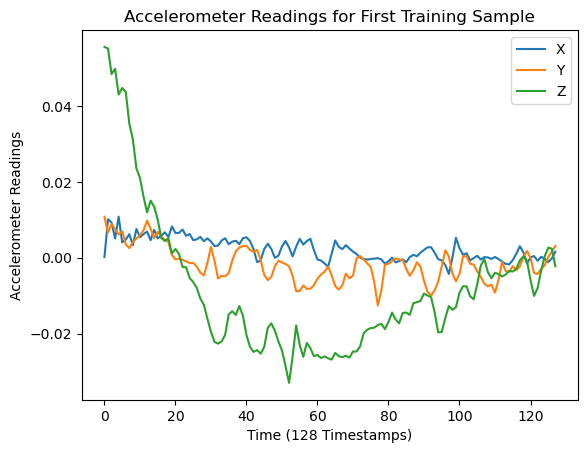

In [18]:
import matplotlib.pyplot as plt

# Get the accelerometer readings for the first training sample
acc_data = trainX[0][:, :3]

# Create a line plot of the accelerometer readings over time
plt.plot(acc_data)
plt.title('Accelerometer Readings for First Training Sample')
plt.xlabel('Time (128 Timestamps)')
plt.ylabel('Accelerometer Readings')
plt.legend(['X', 'Y', 'Z'])
plt.show()

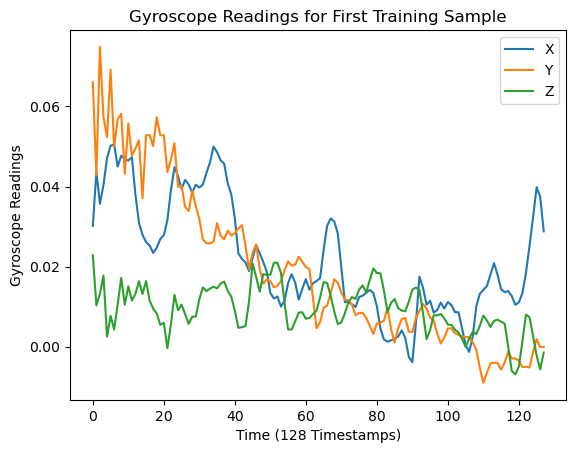

In [19]:
import matplotlib.pyplot as plt

# Get the accelerometer readings for the first training sample
acc_data = trainX[0][:, 3:6]

# Create a line plot of the accelerometer readings over time
plt.plot(acc_data)
plt.title('Gyroscope Readings for First Training Sample')
plt.xlabel('Time (128 Timestamps)')
plt.ylabel('Gyroscope Readings')
plt.legend(['X', 'Y', 'Z'])
plt.show()

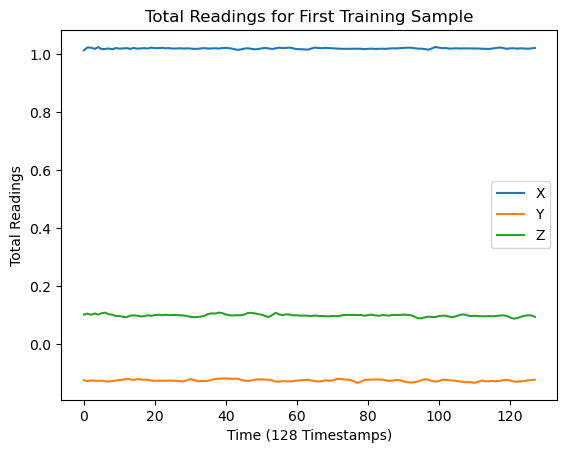

In [20]:
import matplotlib.pyplot as plt

# Get the accelerometer readings for the first training sample
acc_data = trainX[0][:, 6:9]

# Create a line plot of the accelerometer readings over time
plt.plot(acc_data)
plt.title('Total Readings for First Training Sample')
plt.xlabel('Time (128 Timestamps)')
plt.ylabel('Total Readings')
plt.legend(['X', 'Y', 'Z'])
plt.show()

In [21]:
train_labels = np.argmax(trainy, axis=1)
test_labels = np.argmax(testy, axis=1)
train_label_counts = np.bincount(train_labels)
test_label_counts = np.bincount(test_labels)

In [22]:
labels = ['walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing', 'laying']

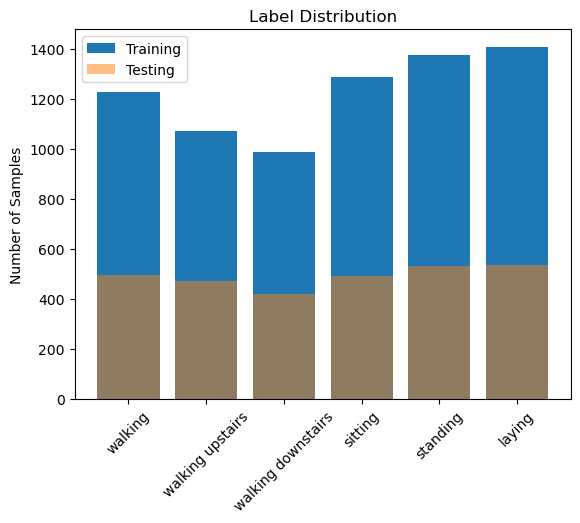

In [23]:
fig, ax = plt.subplots()
train_bars = ax.bar(labels, train_label_counts, label='Training')
test_bars = ax.bar(labels, test_label_counts, label='Testing', alpha=0.5)
ax.set_ylabel('Number of Samples')
ax.set_title('Label Distribution')
ax.legend()
plt.xticks(rotation=45)
plt.show()

Below we're looking to demonstrate the variance in the different features as they pertain to the label. There's clearly a difference in certain activities based on the data the accelerometer and gyroscope collect data. Even with the small amount of data a ML model should do well enough to achieve strong accuracy.

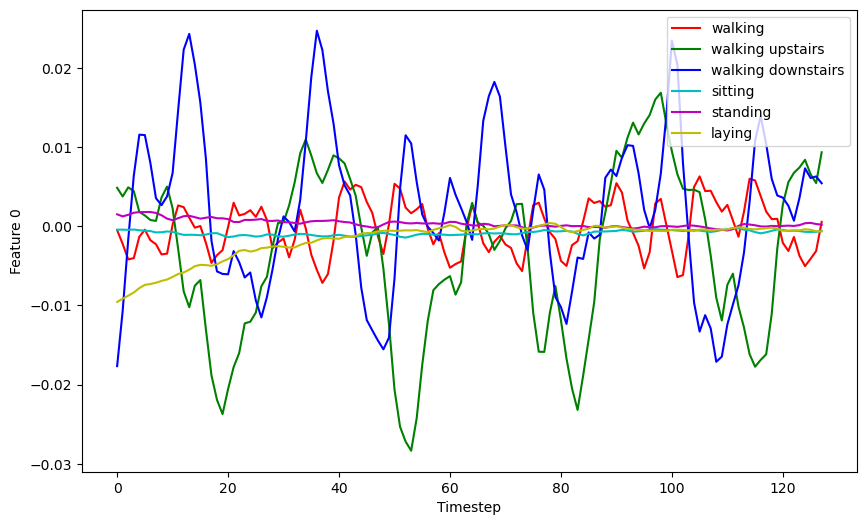

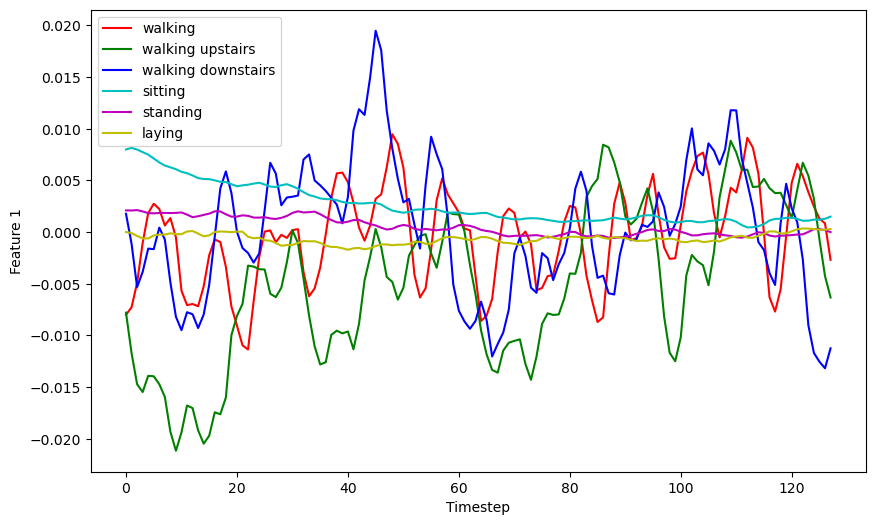

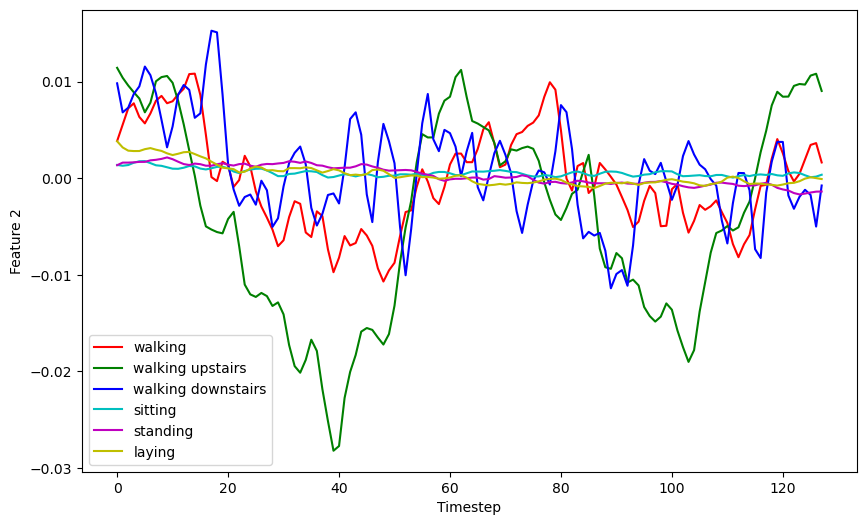

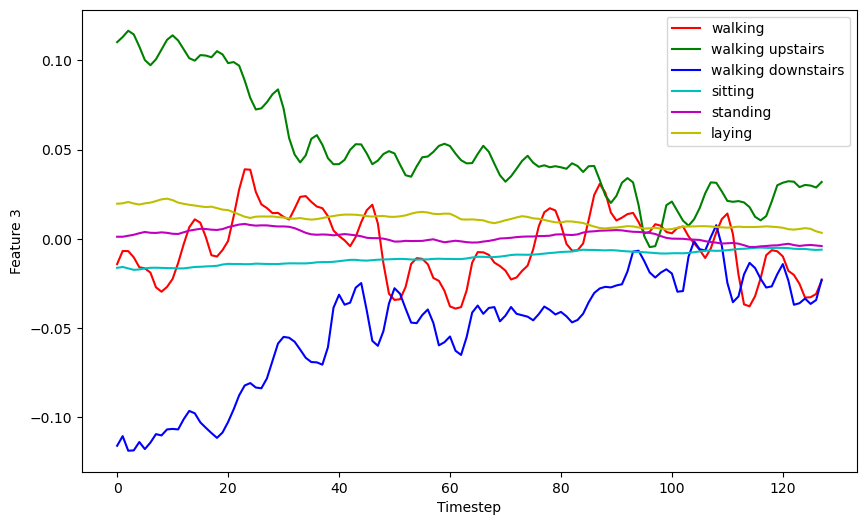

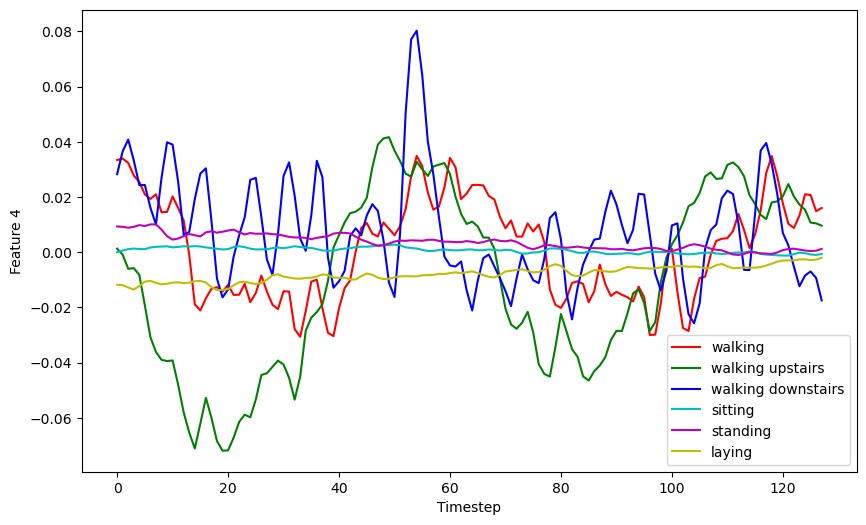

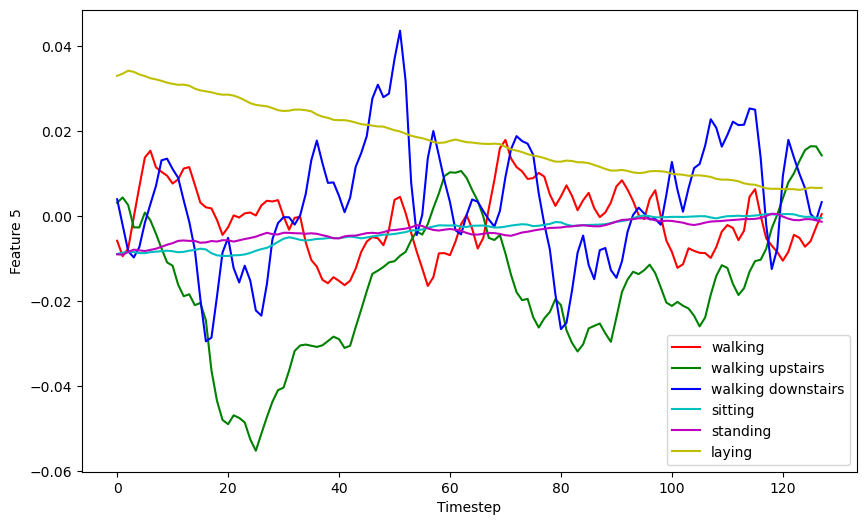

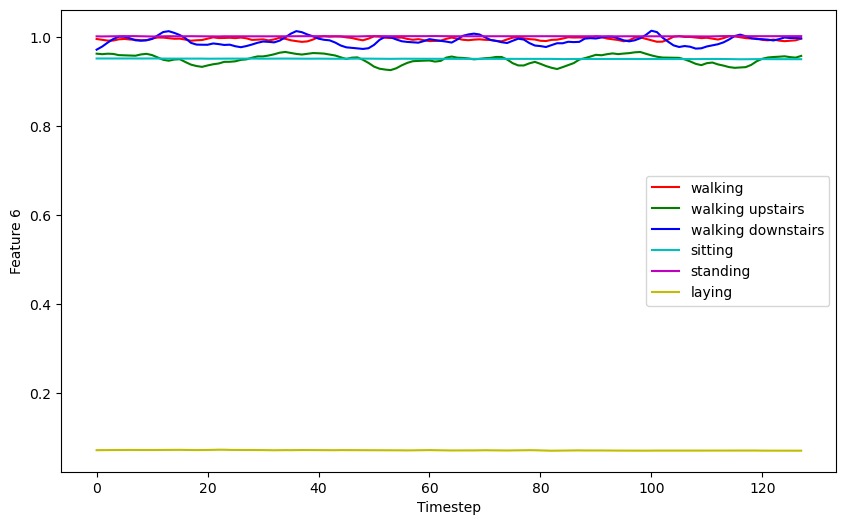

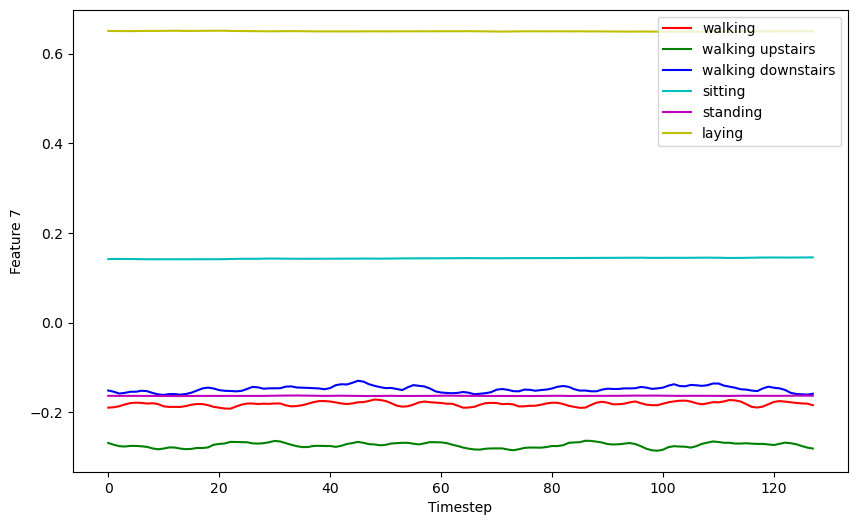

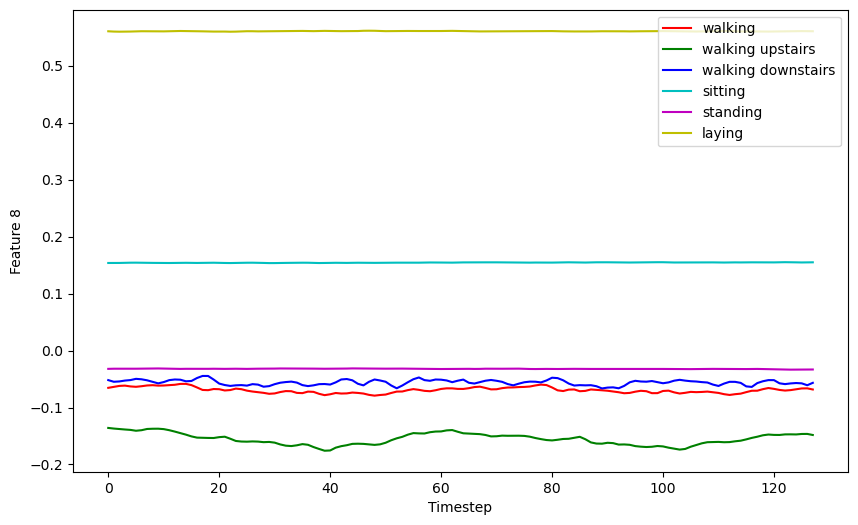

In [24]:
# Create a list of labels
labels = ['walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing', 'laying']

# Create a list of colors for each label
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Create a line plot for each feature and label combination
for f in range(9):
    plt.figure(figsize=(10, 6))
    for label, color in zip(range(len(labels)), colors):
        plt.plot(trainX[train_labels==label, :, f].mean(axis=0), color=color, label=labels[label])
    plt.xlabel('Timestep')
    plt.ylabel('Feature {}'.format(f))
    plt.legend()
    plt.show()

# Building and Evaluating Models

I experiemented with a couple models here including:

1. LSTM
2. 1D Conv Net
3. RNN
4. Multiheaded 1D CNN
5. Time Distributed 1D Conv Net
6. 2D Conv LSTM Model

Each model was kept pretty simple as I was planning to optimize and deepen or widen the model after the fact. This was just to give me an idea of what structure might work best here.

In [75]:
model = Sequential([
    Conv1D(filters = 64, kernel_size = 3, activation = 'relu', input_shape = (128, 9)), 
    Conv1D(filters = 64, kernel_size = 3, activation = 'relu'), 
    MaxPooling1D(pool_size = 2), 
    Flatten(), 
    Dense(100, activation = 'relu'), 
    Dense(6, activation = 'softmax')
])

In [181]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [182]:
history = model.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, verbose = verbose)

In [183]:
history.history['accuracy']

[0.8569096922874451,
 0.9480413198471069,
 0.9442328810691833,
 0.9557943344116211,
 0.9532099962234497,
 0.956066370010376,
 0.9605549573898315,
 0.9570184946060181,
 0.9566104412078857,
 0.9650435447692871]

In [184]:
_, accuracy = model.evaluate(testX, testy, batch_size = batch_size, verbose = 0)

In [185]:
print("1D Convolutional Neural Network Accuracy: ", accuracy * 100)

1D Convolutional Neural Network Accuracy:  89.88802433013916


In [186]:
model2 = Sequential([
    LSTM(units = 64, activation = 'relu', input_shape = (128, 9)), 
    Dense(units = 100, activation = 'relu'), 
    Dense(units = 6, activation = 'softmax')
])

In [187]:
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [188]:
history2 = model2.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, verbose = verbose)

In [189]:
history2.history['accuracy']

[0.5344123840332031,
 0.6324809789657593,
 0.6549238562583923,
 0.6619967222213745,
 0.604733407497406,
 0.6478509306907654,
 0.6660772562026978,
 0.6739662885665894,
 0.6856637597084045,
 0.6927366852760315]

In [190]:
_, accuracy = model2.evaluate(testX, testy, batch_size = batch_size, verbose = 0)

In [191]:
print("Basic Long Short Term Memory Model: ", accuracy * 100)

Basic Long Short Term Memory Model:  63.657957315444946


In [192]:
model3 = Sequential([
    SimpleRNN(units = 64, activation = 'relu', input_shape = (128, 9)), 
    Dense(units = 100, activation = 'relu'), 
    Dense(units = 6, activation = 'softmax')
])

In [193]:
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [194]:
history3 = model3.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, verbose = verbose)

In [195]:
history3.history['accuracy']

[0.6154787540435791,
 0.7357181906700134,
 0.7712187170982361,
 0.8397715091705322,
 0.8828890323638916,
 0.8754080533981323,
 0.9001632332801819,
 0.918933629989624,
 0.8775843381881714,
 0.8472524285316467]

In [196]:
_, accuracy = model3.evaluate(testX, testy, batch_size = batch_size, verbose = 0)

In [197]:
print("Basic Recurrent Neural Network Accuracy: ", accuracy * 100)

Basic Recurrent Neural Network Accuracy:  80.82796335220337


In [207]:
# Define input shapes
input_shape = (128, 3)
num_labels = 6

# Define the input layers
input_layer_1 = tf.keras.layers.Input(shape=input_shape)
input_layer_2 = tf.keras.layers.Input(shape=input_shape)
input_layer_3 = tf.keras.layers.Input(shape=input_shape)

# Define the first convolutional layer
conv_layer_1 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer_1)
conv_layer_1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv_layer_1)
conv_layer_1 = tf.keras.layers.Dropout(0.2)(conv_layer_1)

# Define the second convolutional layer
conv_layer_2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer_2)
conv_layer_2 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv_layer_2)
conv_layer_2 = tf.keras.layers.Dropout(0.2)(conv_layer_2)

# Define the third convolutional layer
conv_layer_3 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer_3)
conv_layer_3 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv_layer_3)
conv_layer_3 = tf.keras.layers.Dropout(0.2)(conv_layer_3)

# Flatten the output from the convolutional layers
flatten_layer_1 = tf.keras.layers.Flatten()(conv_layer_1)
flatten_layer_2 = tf.keras.layers.Flatten()(conv_layer_2)
flatten_layer_3 = tf.keras.layers.Flatten()(conv_layer_3)

# Concatenate the outputs from the two convolutional layers
concat_layer = tf.keras.layers.Concatenate()([flatten_layer_1, flatten_layer_2, flatten_layer_3])

# Define the first dense layer
dense_layer_1 = tf.keras.layers.Dense(64, activation='relu')(concat_layer)
dense_layer_1 = tf.keras.layers.Dropout(0.2)(dense_layer_1)

# Define the output layer
output_layer = tf.keras.layers.Dense(num_labels, activation='softmax')(dense_layer_1)

# Define the model with two inputs and one output
model = tf.keras.models.Model(inputs=[input_layer_1, input_layer_2, input_layer_3], outputs=output_layer)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [208]:
# Separate the training data into its three components
x_train_total = trainX[:, :, :3]
x_train_body_acc = trainX[:, :, 3:6]
x_train_body_gyro = trainX[:, :, 6:]

# Separate the test data into its three components
x_test_total = testX[:, :, :3]
x_test_body_acc = testX[:, :, 3:6]
x_test_body_gyro = testX[:, :, 6:]

history = model.fit([x_train_total, x_train_body_acc, x_train_body_gyro], trainy, epochs = epochs, batch_size = batch_size, verbose = verbose)

In [209]:
history.history['accuracy']

[0.8071272969245911,
 0.9129488468170166,
 0.9389281868934631,
 0.9423286318778992,
 0.9460011124610901,
 0.9511697292327881,
 0.9549782276153564,
 0.9567464590072632,
 0.9590587615966797,
 0.9581066370010376]

In [210]:
_, accuracy = model.evaluate([x_test_total, x_test_body_acc, x_test_body_gyro], testy, batch_size = batch_size, verbose = 0)

In [211]:
print("Multiheaded 1D CNN Model Accuracy: ", accuracy * 100)

Multiheaded 1D CNN Model Accuracy:  90.32914638519287


In [216]:
# Define the input shape
input_shape = (128, 9)

# Define the number of classes
num_classes = 6

# Define the input layer
inputs = Input(shape=input_shape)

# Define the convolutional layers
x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)

# Define the LSTM layer
x = LSTM(units=64)(x)

# Define the output layers
outputs = Dense(units=num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 9)]          0         
                                                                 
 conv1d_17 (Conv1D)          (None, 126, 64)           1792      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 63, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 61, 128)           24704     
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 64)                4940

In [217]:
history = model.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, verbose = verbose)

In [218]:
history.history['accuracy']

[0.804951012134552,
 0.9261425733566284,
 0.9457290768623352,
 0.9479053616523743,
 0.9517138004302979,
 0.9537540674209595,
 0.9496735334396362,
 0.9545701742172241,
 0.9541621208190918,
 0.9585146903991699]

In [219]:
_, accuracy = model.evaluate(testX, testy, batch_size = batch_size, verbose = 0)

In [222]:
print("CNN LSTM Network Model Accuracy: ", accuracy * 100)

CNN LSTM Network Model Accuracy:  91.48286581039429


In [234]:
trainX, trainy, testX, testy = load_dataset()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [235]:
# define model
verbose, epochs, batch_size = 0, 25, 64
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [236]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [237]:
# fit network
history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

In [238]:
history.history['accuracy']

[0.7271490693092346,
 0.9139009714126587,
 0.9411044716835022,
 0.9460011124610901,
 0.9496735334396362,
 0.9533460140228271,
 0.953618049621582,
 0.954842209815979,
 0.9552502632141113,
 0.9530739784240723,
 0.9545701742172241,
 0.9504896402359009,
 0.9597388505935669,
 0.9600108861923218,
 0.9568824768066406,
 0.9591947793960571,
 0.9601469039916992,
 0.9635473489761353,
 0.9616430997848511,
 0.9654515981674194,
 0.9676278829574585,
 0.9659956693649292,
 0.9664037227630615,
 0.9664037227630615,
 0.9706202149391174]

In [239]:
_, accuracy = model.evaluate(testX, testy, batch_size = batch_size, verbose = 0)

In [240]:
print("Time Distributed CNN LSTM Network Model Accuracy: ", accuracy * 100)

Time Distributed CNN LSTM Network Model Accuracy:  90.60060977935791


In [268]:
trainX, trainy, testX, testy = load_dataset()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [269]:
# define model
verbose, epochs, batch_size = 0, 25, 64
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 4, 32
trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [258]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [259]:
# fit network
history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

In [260]:
history.history['accuracy']

[0.7561208009719849,
 0.9234222173690796,
 0.9397442936897278,
 0.9484493732452393,
 0.9503536224365234,
 0.9498095512390137,
 0.9521218538284302,
 0.9534820318222046,
 0.957290530204773,
 0.9593307971954346,
 0.9609630107879639,
 0.956066370010376,
 0.9604189395904541,
 0.9601469039916992,
 0.9621871709823608,
 0.9647715091705322,
 0.9673558473587036,
 0.9635473489761353,
 0.9688519835472107,
 0.9649075269699097,
 0.9681719541549683,
 0.9685800075531006,
 0.9658596515655518,
 0.9700761437416077,
 0.9723884463310242]

In [261]:
_, accuracy = model.evaluate(testX, testy, batch_size = batch_size, verbose = 0)

In [262]:
print("Conv LSTM 2 Dimension Network Model Accuracy: ", accuracy * 100)

Conv LSTM 2 Dimension Network Model Accuracy:  91.41499996185303


# Hyperparameter Tuning

For hyperparameter tuning I just for looped through three variables within the model and discovered that a 200 neuron Dense layer was better.

In [325]:
def create_model(filters = 64, kernel_size = (1,3), dropout_rate = 0.5, dense_units = 100):
    #load the data
    trainX, trainy, testX, testy = load_dataset()
    # define model
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape into subsequences (samples, time steps, rows, cols, channels)
    n_steps, n_length = 4, 32
    trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    # compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit networkabs
    history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    #print results
    print(history.history['accuracy'][-1:])
    #evaluate on test set
    _, accuracy = model.evaluate(testX, testy, batch_size = batch_size, verbose = 0)
    #print accuracy after eval
    print("Conv LSTM 2 Dimension Network Model Accuracy: ", accuracy * 100)

In [326]:
filters = [32, 64, 128]

for filter_size in filters:
    create_model(filters = filter_size) 

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
[0.962867259979248]
Conv LSTM 2 Dimension Network Model Accuracy:  90.80420732498169
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
[0.9703481793403625]
Conv LSTM 2 Dimension Network Model Accuracy:  91.85612201690674
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
[0.9721164107322693]
Conv LSTM 2 Dimension Network Model Accuracy:  91.58466458320618


In [328]:
dropout_rates = [0.2, 0.5, 0.8]

for dropout_rate in dropout_rates:
    create_model(dropout_rate = dropout_rate) 

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
[0.972660481929779]
Conv LSTM 2 Dimension Network Model Accuracy:  90.63454270362854
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
[0.9634113311767578]
Conv LSTM 2 Dimension Network Model Accuracy:  90.90600609779358
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
[0.9589227437973022]
Conv LSTM 2 Dimension Network Model Accuracy:  89.95589017868042


In [329]:
dense_units = [50, 100, 200]

for dense_units in dense_units:
    create_model(dense_units = dense_units) 

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
[0.9672198295593262]
Conv LSTM 2 Dimension Network Model Accuracy:  89.20936584472656
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
[0.9680359363555908]
Conv LSTM 2 Dimension Network Model Accuracy:  90.05768299102783
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
[0.972660481929779]
Conv LSTM 2 Dimension Network Model Accuracy:  91.14353656768799


# Finding a model that generalizes well

To find a model that generalizes well I used early stopping and callbacks to find the right balance. Ultimately, early stopping was the right fit because variance remained the same at after each epoch and results didn't necessaily improve after 5 epochs.

I also experimented with different optimizers and learning rates for each. I tried 0.001 and 0.035 as well as the Nadam, AdamW and Adam optimizer. Adam was the winner.

In [69]:
trainX, trainy, testX, testy = load_dataset()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [70]:
# define model
verbose, epochs, batch_size = 0, 25, 64
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 4, 32
trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))

final_model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)), 
    Dropout(0.5), 
    Flatten(), 
    Dense(200, activation='relu'), 
    Dense(n_outputs, activation='softmax')
])

In [71]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# define the callback
#checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=3)

optimizer = tf.keras.optimizers.experimental.Adam()

# compile and fit the model with the callback
final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
final_model.fit(trainX, trainy, epochs=25, batch_size=32, validation_data=(testX, testy), callbacks=[early_stop])

Epoch 1/25
230/230 [==============================] - 5s 16ms/step - loss: 0.4511 - accuracy: 0.8179 - val_loss: 0.4767 - val_accuracy: 0.8731
Epoch 2/25
230/230 [==============================] - 4s 16ms/step - loss: 0.1693 - accuracy: 0.9340 - val_loss: 0.5200 - val_accuracy: 0.8748
Epoch 3/25
230/230 [==============================] - 3s 15ms/step - loss: 0.1382 - accuracy: 0.9436 - val_loss: 0.4027 - val_accuracy: 0.8897
Epoch 4/25
230/230 [==============================] - 3s 15ms/step - loss: 0.1190 - accuracy: 0.9504 - val_loss: 0.5850 - val_accuracy: 0.8884
Epoch 5/25
230/230 [==============================] - 3s 15ms/step - loss: 0.1142 - accuracy: 0.9524 - val_loss: 0.5937 - val_accuracy: 0.8989
Epoch 6/25
230/230 [==============================] - 4s 15ms/step - loss: 0.1189 - accuracy: 0.9494 - val_loss: 0.5470 - val_accuracy: 0.8968


In [72]:
final_model.save('human_activity_recognizer_model.h5')

In [73]:
final_model.save_weights('human_activity_recognizer_model_weights.h5')